# Model training monitoring
In this tutorial, we will focus on how to monitor the QSPRpred model training process.
The main goal of this tutorial is to show how to use the `monitoring` module to monitor the model training process.
The training steps themselves are not the focus of this tutorial, if you want to learn more about the training process, please refer to the [model assessment](../../basics/modelling/model_assessment.ipynb) tutorial or the [hyperparameter optimization](hyperparameter_optimization.ipynb) tutorial.

We will start by loading in the data and model we want to monitor.
In this tutorial, we will use a fully connected neural network model, to also show the monitoring of the fitting process, which is not relevant for K-Nearest Neighbors models used in the other tutorials. If you want to know more about the neural net, please refer to the [deep learning models](deep_learning_models.ipynb) tutorial.

In [1]:
import os

from IPython.display import display

from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP

os.makedirs("../../tutorial_output/data", exist_ok=True)

# Create dataset
dataset = QSPRDataset.fromTableFile(
    filename="../../tutorial_data/A2A_LIGANDS.tsv",
    store_dir="../../tutorial_output/data",
    name="MonitoringTutorialDataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
    random_state=42
)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=RandomSplit(test_fraction=0.2, dataset=dataset),
    feature_calculators=[MorganFP(radius=3, nBits=2048)],
    recalculate_features=True,
)

dataset.getDF().head()

# Create model
from qsprpred.extra.gpu.models.dnn import DNNModel

os.makedirs("../../tutorial_output/models", exist_ok=True)
model = DNNModel(
    base_dir='../../tutorial_output/models',
    name='MonitoringTutorialModel',
    patience=3,
    tol=0.01,
)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Basic setup

Monitors are used to track the training progress in addition to the files with predictions that are generated by default. Instances of the `Monitor` class can be passed to `HyperparameterOptimization` and `ModelAssessment` classes as well as the fit function of a `QSPRModel` to monitor the training process.

By default, a `BaseMonitor` is used. This monitor tracks the training progress by keeping track of predictions, metric values and loss internallly.

The `BaseMonitor` passed to a `CrossValAssessor` will hold the trainings and test sets for each fold,
as well as the generated predictions and in case of fitting a neural network, the loss and metric values for each epoch.
If a `BaseMonitor` is passed to a `HyperparameterOptimization` object, it will contain all the previously mentioned values for each hyperparameter combination as well as the scores for each hyperparameter combination.
Here we will show how you can access these values.

In this example we will show the scores of the hyperparameter combinations for a neural network model grid search,
and the predictions of the folds of the cross-validation.

In [2]:
from qsprpred.models import GridSearchOptimization
from qsprpred.models import TestSetAssessor, CrossValAssessor

# Define the search space
search_space = {"lr": [1e-4, 1e-3, ], "neurons_h1": [100, 200]}

gridsearcher = GridSearchOptimization(
    param_grid=search_space,
    model_assessor=TestSetAssessor(scoring='r2')
)
gridsearcher.optimize(model, dataset)

# show grid search results
display(gridsearcher.monitor.scores.head())

# Create a CrossValAssessor object
assessor = CrossValAssessor('r2')
assessor(model, dataset)

# show cross validation results
display(assessor.monitor.predictions.head())

qsprpred - WARNING - Random state supplied, but alg <class 'qsprpred.extra.gpu.models.neural_network.STFullyConnected'> does not support it. Ignoring this setting.


,aggregated_score,fold_scores
Iteration,,
0,-1.652565,[-1.6525652398602855]
1,-0.836898,[-0.8368975522437034]
2,0.459826,[0.4598257556451889]
3,0.469684,[0.469683527334269]


,pchembl_value_Mean_Label,pchembl_value_Mean_Prediction,Fold
QSPRID,,,
MonitoringTutorialDataset_0221,7.20,6.886100,0.0
MonitoringTutorialDataset_3260,6.02,5.978072,0.0
MonitoringTutorialDataset_3675,8.32,8.597543,0.0
MonitoringTutorialDataset_3330,8.02,6.919986,0.0
MonitoringTutorialDataset_3484,6.77,7.532026,0.0


Or show the training and test set for the first fold:

In [3]:
display(assessor.monitor.foldData[0]["X_train"].head())
display(assessor.monitor.foldData[0]["y_train"].head())

,MorganFP_0,MorganFP_1,MorganFP_2,MorganFP_3,MorganFP_4,MorganFP_5,MorganFP_6,MorganFP_7,MorganFP_8,MorganFP_9,...,MorganFP_2038,MorganFP_2039,MorganFP_2040,MorganFP_2041,MorganFP_2042,MorganFP_2043,MorganFP_2044,MorganFP_2045,MorganFP_2046,MorganFP_2047
QSPRID,,,,,,,,,,,,,,,,,,,,,
MonitoringTutorialDataset_3644,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
MonitoringTutorialDataset_2459,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MonitoringTutorialDataset_1315,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
MonitoringTutorialDataset_1017,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
MonitoringTutorialDataset_0088,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


,pchembl_value_Mean
QSPRID,
MonitoringTutorialDataset_3644,8.07
MonitoringTutorialDataset_2459,4.80
MonitoringTutorialDataset_1315,5.50
MonitoringTutorialDataset_1017,6.44
MonitoringTutorialDataset_0088,7.66


You can also access the best parameters and scores of the hyperparameter optimization easily:

In [4]:
print(f"best parameter values: {gridsearcher.monitor.bestParameters}")
print(f"best score: {gridsearcher.monitor.bestScore}")

best parameter values: {'lr': 0.001, 'neurons_h1': 200}
best score: 0.469683527334269


As well as individual fits:

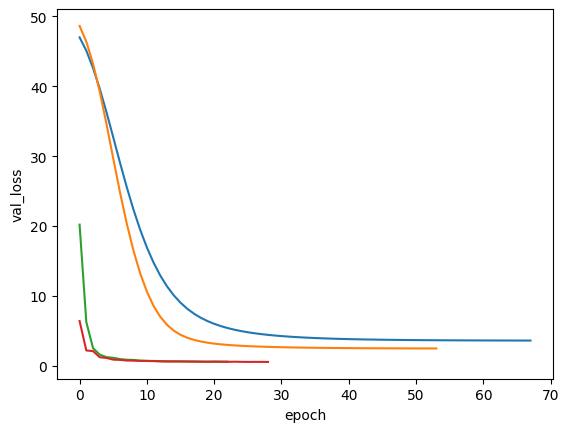

In [5]:
import seaborn as sns

for assessment in gridsearcher.monitor.assessments.values():
    sns.lineplot(assessment["fits"][0]["fitLog"], x="epoch", y="val_loss")

## File monitoring

In addition to the base monitoring, the `FileMonitor` can be used to save the predictions, metrics and loss to files.
Results will automatically be saved to the model directory.


In [6]:
from qsprpred.models import FileMonitor
from qsprpred.models import EarlyStoppingMode

# Define the search space
search_space = {"lr": [1e-4, 1e-3, ], "neurons_h1": [100, 200]}

gridsearcher = GridSearchOptimization(
    param_grid=search_space,
    model_assessor=TestSetAssessor(scoring='r2'),
    monitor=FileMonitor()
)
gridsearcher.optimize(model, dataset)

# Create a CrossValAssessor object
CrossValAssessor('r2', mode=EarlyStoppingMode.RECORDING)(model, dataset,
                                                         monitor=FileMonitor())
TestSetAssessor('r2')(model, dataset, monitor=FileMonitor())

# fit the model on the whole dataset
_ = model.fitDataset(dataset, monitor=FileMonitor())

We can for example load the hyperparameter optimization results from the file and visualize them:

<Axes: xlabel='None', ylabel='aggregated_score'>

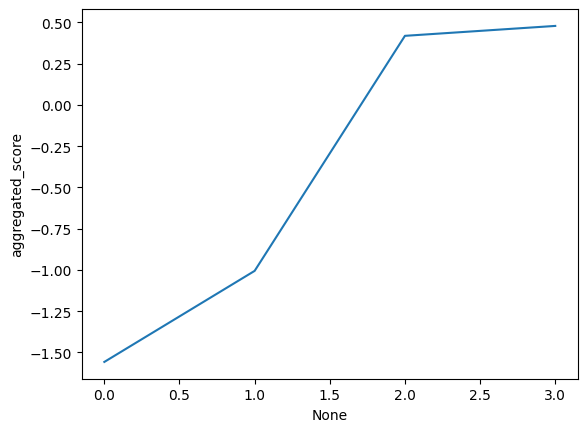

In [7]:
import pandas as pd
import seaborn as sns

hyperparamopt_scores = pd.read_csv(
    f"{model.outDir}/GridSearchOptimization/GridSearchOptimization_scores.tsv",
    sep="\t").head()
sns.lineplot(y="aggregated_score", data=hyperparamopt_scores,
             x=hyperparamopt_scores.index)

## Weights & Biases monitoring

Furthermore, the `WandbMonitor` can be used to track the training progress on the [Weights & Biases platform](https://wandb.ai).

If you want to use the `WandbMonitor`, you first need to install the `wandb` package and create a free account.
When you run the `WandbMonitor` for the first time, you will be asked to login to your account.

In [8]:
# check if WandB is installed and only run then
try:
    from qsprpred.models import GridSearchOptimization
    from qsprpred.models import CrossValAssessor, TestSetAssessor
    from qsprpred.models import WandBMonitor
    from qsprpred.models import EarlyStoppingMode

    os.environ["WANDB_SILENT"] = "true"

    # Define the search space
    search_space = {"lr": [1e-4, 1e-3, ], "neurons_h1": [100, 200]}

    gridsearcher = GridSearchOptimization(
        param_grid=search_space,
        model_assessor=TestSetAssessor('r2'),
        monitor=WandBMonitor(project_name="tutorial")
    )
    gridsearcher.optimize(model, dataset)

    # Create a CrossValAssessor object
    CrossValAssessor('r2', mode=EarlyStoppingMode.RECORDING)(model, dataset,
                                                             monitor=WandBMonitor(
                                                                 project_name="tutorial"))
    TestSetAssessor('r2')(model, dataset, monitor=WandBMonitor(project_name="tutorial"))

    # fit the model on the whole dataset
    model.fitDataset(dataset, monitor=WandBMonitor(project_name="tutorial"))

except ImportError:
    print(
        "wandb is not installed, make sure to install it to run this part of the tutorial.")


wandb is not installed, make sure to install it to run this part of the tutorial.
